In [1]:
!pip install tqdm

    100% |████████████████████████████████| 51kB 4.6MB/s 


In [2]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

In [4]:
import zipfile
from tqdm import tqdm,trange
trainzip = zipfile.ZipFile('drive/Data/img_align_celeba.zip')
ilist = trainzip.infolist()
for i in trange(len(ilist)):
    trainzip.extract(ilist[i])

100%|██████████| 202600/202600 [00:54<00:00, 3730.19it/s]


# Gender Prediction on CelebA

## Import Libraries

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Convolution2D,MaxPooling2D,Dense,Dropout,Activation,Flatten,BatchNormalization
from keras.callbacks import ModelCheckpoint,EarlyStopping
from keras import backend as K
import seaborn as sns
from sklearn.metrics import accuracy_score,classification_report
from sklearn.ensemble import RandomForestRegressor
from sklearn.externals import joblib
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn import svm
import glob
import h5py
import cv2

Using TensorFlow backend.


## Define constants

In [0]:
num_epochs = 5
batch_size = 64
train_size = 162770
train_steps = train_size//batch_size
filelist = sorted(glob.glob("img_align_celeba/*.jpg"))

## Load Data

In [7]:
celeba_attr = open('drive/Data/list_attr_celeba.txt')
label_df = pd.read_csv(celeba_attr,sep='\s+')
label_df.head()

,filename,5_o_Clock_Shadow,Arched_Eyebrows,Attractive,Bags_Under_Eyes,Bald,Bangs,Big_Lips,Big_Nose,Black_Hair,...,Sideburns,Smiling,Straight_Hair,Wavy_Hair,Wearing_Earrings,Wearing_Hat,Wearing_Lipstick,Wearing_Necklace,Wearing_Necktie,Young
0,000001.jpg,-1,1,1,-1,-1,-1,-1,-1,-1,...,-1,1,1,-1,1,-1,1,-1,-1,1
1,000002.jpg,-1,-1,-1,1,-1,-1,-1,1,-1,...,-1,1,-1,-1,-1,-1,-1,-1,-1,1
2,000003.jpg,-1,-1,-1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,1,-1,-1,-1,-1,-1,1
3,000004.jpg,-1,-1,1,-1,-1,-1,-1,-1,-1,...,-1,-1,1,-1,1,-1,1,1,-1,1
4,000005.jpg,-1,1,1,-1,-1,-1,1,-1,-1,...,-1,-1,-1,-1,-1,-1,1,-1,-1,1


In [0]:
Xy = list(zip(filelist,(label_df.loc[:,["No_Beard","Goatee","5_o_Clock_Shadow","Mustache"]].values==1).astype(int)))
X = []
y = []
for i in Xy:
    X.append(i[0])
    y.append(i[1])
X = np.array(X)
y = np.array(y)

In [0]:
def get_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    img = img[20:198,:]
    img = cv2.resize(img,(64,64))
    img = (img.astype(float)/255)
    return img

In [0]:
def get_batches(batch_size,X,y):
  assert(len(X)==len(y))
  while True:
    steps = len(X)//batch_size
    for i in range(steps):
        X_batch = []
        for j in range(i*batch_size,(i+1)*batch_size):
            X_batch.append(get_image(X[j]))
        X_batch = np.array(X_batch)
        y_batch = y[i*batch_size:(i+1)*batch_size]
        yield X_batch,y_batch

## VGG-16 Model

In [11]:
model = Sequential()
model.add(Convolution2D(32,(3,3),activation='relu',input_shape=(64,64,3),padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(32,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(64,(3,3),activation='relu',padding='same'))
model.add(MaxPooling2D(pool_size=(2,2),strides=(2,2)))
model.add(BatchNormalization())
model.add(Convolution2D(128,(3,3),activation='relu',padding='same'))
model.add(BatchNormalization())
model.add(Convolution2D(128,(3,3),activation='relu',padding='same'))
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1024,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(4,activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 64, 64, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 64, 64, 32)        128       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        18496     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
__________

## Training the Model

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, random_state=1)
train_gen = get_batches(batch_size,X_train,y_train)
test_gen = get_batches(batch_size,X_test,y_test)
train_steps = len(X_train)//batch_size
val_steps = len(X_test)//batch_size

In [13]:
model.fit_generator(train_gen,steps_per_epoch=train_steps,epochs=num_epochs,validation_data=test_gen,validation_steps=val_steps,verbose=1)

Epoch 1/5
2531/2532 [============================>.] - ETA: 0s - loss: 0.1836 - acc: 0.9237

2532/2532 [==============================] - 438s 173ms/step - loss: 0.1836 - acc: 0.9237 - val_loss: 0.1278 - val_acc: 0.9453
Epoch 2/5
 453/2532 [====>.........................] - ETA: 5:27 - loss: 0.1294 - acc: 0.9447

2531/2532 [============================>.] - ETA: 0s - loss: 0.1245 - acc: 0.9467

2532/2532 [==============================] - 437s 173ms/step - loss: 0.1245 - acc: 0.9467 - val_loss: 0.1381 - val_acc: 0.9414
Epoch 3/5
 453/2532 [====>.........................] - ETA: 5:26 - loss: 0.1150 - acc: 0.9507

2531/2532 [============================>.] - ETA: 0s - loss: 0.1124 - acc: 0.9517

2532/2532 [==============================] - 436s 172ms/step - loss: 0.1124 - acc: 0.9517 - val_loss: 0.1175 - val_acc: 0.9501
Epoch 4/5
 453/2532 [====>.........................] - ETA: 5:26 - loss: 0.1078 - acc: 0.9540

2531/2532 [============================>.] - ETA: 0s - loss: 0.1039 - acc: 0.9553

2532/2532 [==============================] - 436s 172ms/step - loss: 0.1039 - acc: 0.9554 - val_loss: 0.1223 - val_acc: 0.9500
Epoch 5/5
 453/2532 [====>.........................] - ETA: 5:26 - loss: 0.0963 - acc: 0.9578

2531/2532 [============================>.] - ETA: 0s - loss: 0.0945 - acc: 0.9588

2532/2532 [==============================] - 436s 172ms/step - loss: 0.0945 - acc: 0.9589 - val_loss: 0.1272 - val_acc: 0.9479


## Results

In [14]:
pred_gen = get_batches(batch_size,X_test,y_test)
y_pred = model.predict_generator(pred_gen,steps=val_steps,verbose=1)

633/633 [==============================] - 41s 65ms/step


In [15]:
y_true = y_test[:len(y_pred)]
y_pred_int = np.round(y_pred)
print(classification_report(y_true,y_pred_int))

             precision    recall  f1-score   support

          0       0.94      0.99      0.96     33795
          1       0.74      0.67      0.70      2563
          2       0.85      0.38      0.52      4469
          3       0.66      0.31      0.42      1675

avg / total       0.91      0.88      0.88     42502



In [0]:
def check_and_eval(image_number):
    X = cv2.imread(filelist[image_number-1])
    X = cv2.cvtColor(X,cv2.COLOR_BGR2RGB)
    plt.imshow(X)
    plt.show()
    X = get_image(filelist[image_number-1]).reshape(-1,64,64,1)
    y_pred = model.predict(X)
    y_true = (label_df["Male"][image_number-1]+1)//2
    if(y_true==1):
        print("Label is Male")
    else:
        print("Label is Female")
    print("Male Probability: {:.4f}\tFemale Probability: {:.4f}".format((y_pred[0][0])*100.0,(1-y_pred[0][0])*100.0))
    if(y_pred<0.5):
        print("Prediction: Female")
    else:
        print("Prediction: Male")

In [0]:
interact(check_and_eval, image_number=widgets.IntSlider(min=1,max=len(label_df),value=100))

<function __main__.check_and_eval>

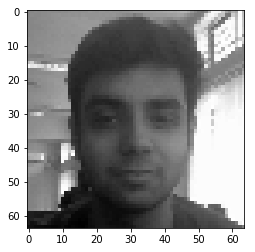

In [0]:
mehul = get_image("../Data/MehulMale.jpg").reshape(64,64)
plt.imshow(mehul,cmap='gray')
plt.show()

In [0]:
y_pred = model.predict(mehul.reshape(-1,64,64,1))
print("Male Probability: {:.4f}\tFemale Probability: {:.4f}".format((y_pred[0][0])*100.0,(1-y_pred[0][0])*100.0))
if(y_pred<0.5):
    print("Prediction: Female")
else:
    print("Prediction: Male")

Male Probability: 96.7324	Female Probability: 3.2676
Prediction: Male


In [0]:
np.unique((label_df.loc[:,["No_Beard","Goatee","5_o_Clock_Shadow","Mustache"]].values==1).astype(int),axis=0,return_counts=True)

(array([[0, 0, 0, 0],
        [0, 0, 0, 1],
        [0, 0, 1, 0],
        [0, 0, 1, 1],
        [0, 1, 0, 0],
        [0, 1, 0, 1],
        [0, 1, 1, 0],
        [0, 1, 1, 1],
        [1, 0, 0, 0],
        [1, 0, 0, 1],
        [1, 0, 1, 0],
        [1, 0, 1, 1],
        [1, 1, 0, 0],
        [1, 1, 0, 1],
        [1, 1, 1, 0]]),
 array([  5971,   2415,  11723,    834,   5213,   3669,   2352,   1264,
        162402,    214,   6316,      8,    186,     13,     19]))

In [0]:
!mkdir drive/Models/LFW_RGB_64/FacialHair
model.save("drive/Models/LFW_RGB_64/Hair/FacialHairNet.hdf5")